This notebooks shows how the number of genes with non-zero coefficients increases as the regularization strength decreases (e.g. C increases).

In [1]:
from eda_import import *

In [2]:
from scripts.sift_LR_L1_genes import load_expr, load_genes, split, generate_df_cv, sort_genes

In [3]:
dise = 'PRAD'
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
n_splits = 10

# random_state = np.random.randint(0, 1e9)
random_state = 593393040
print('random_state: {0}'.format(random_state))

random_state: 593393040


In [4]:
bdf = load_expr(dise)
rsem_genes = load_genes()

In [5]:
bdf.shape

(550, 20407)

In [6]:
Xs = bdf[rsem_genes].values
ys = LabelEncoder().fit_transform(bdf.sstype.values)

In [7]:
Xs_scaled = StandardScaler().fit_transform(Xs)

In [8]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [9]:
# only take idxes corresponding to test set
split_idxes = [_[1] for _ in skf.split(Xs, ys)]

In [10]:
res = []
for curr_c in Cs:
    for i in range(n_splits):
        print(i, end=',')
        clf = LogisticRegression(penalty='l1', C=curr_c, tol=1e-10)

        idxes = np.concatenate(split_idxes[:i + 1])
        sub_Xs = Xs_scaled[idxes]
        sub_ys = ys[idxes]
        clf.fit(sub_Xs, sub_ys)

        gene_coef_pairs = list(zip(rsem_genes, np.abs(clf.coef_[0])))
        df_sorted_genes = sort_genes(gene_coef_pairs)
        res.append((curr_c, sub_Xs.shape[0], df_sorted_genes.shape[0]))
    print()

0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,


In [11]:
df_res = pd.DataFrame(res, columns=['C', 'num_samples', 'num_genes_selected'])

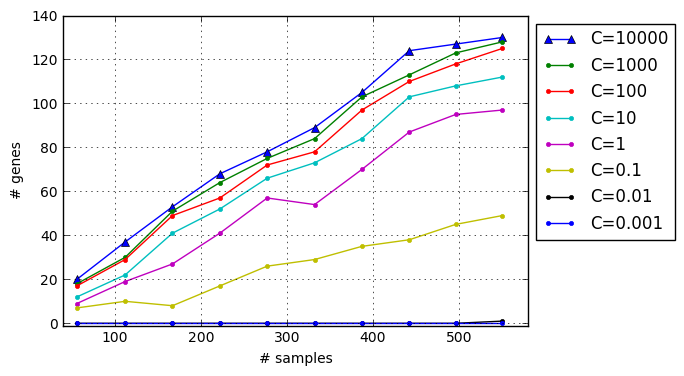

In [21]:
ax = plt.axes()

for k, curr_c in enumerate(reversed(Cs)):
    _df = df_res.query('C == {0}'.format(curr_c)).copy()
    _df.sort_values('num_samples', inplace=True)
    if curr_c < 1:
        label = 'C={0}'.format(curr_c)
    else:
        label = 'C={0:.0f}'.format(curr_c)
    marker = '^' if curr_c >= 1e4 else '.'
    _df.plot(ax=ax, x='num_samples', marker=marker, y='num_genes_selected', label=label)

ax.legend(loc="upper left", bbox_to_anchor=(1,1))

ax.set_xlim(40, 580)
ax.set_ylim(-1)
ax.set_xlabel('# samples')
ax.set_ylabel('# genes')
ax.grid(which='both')

# Repeat the experiment to see reproducibility

In [13]:
df_res_ref = df_res.copy()

In [14]:
res = []
for curr_c in Cs:
    for i in range(n_splits):
        print(i, end=',')
        clf = LogisticRegression(penalty='l1', C=curr_c, tol=1e-10)

        idxes = np.concatenate(split_idxes[:i + 1])
        sub_Xs = Xs_scaled[idxes]
        sub_ys = ys[idxes]
        clf.fit(sub_Xs, sub_ys)

        gene_coef_pairs = list(zip(rsem_genes, np.abs(clf.coef_[0])))
        df_sorted_genes = sort_genes(gene_coef_pairs)
        res.append((curr_c, sub_Xs.shape[0], df_sorted_genes.shape[0]))
    print()
df_res = pd.DataFrame(res, columns=['C', 'num_samples', 'num_genes_selected'])

0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,


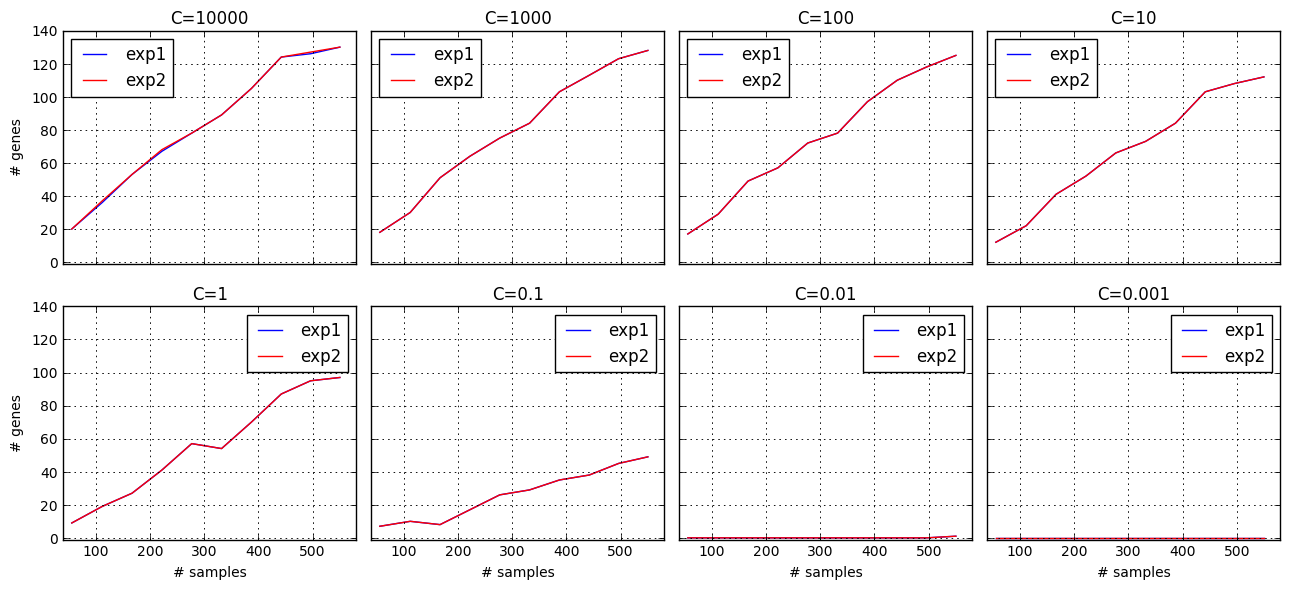

In [20]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(13, 6))
axes = axes.ravel()

for k, curr_c in enumerate(reversed(Cs)):
    ax = axes[k]
    _df1 = df_res_ref.query('C == {0}'.format(curr_c)).copy()
    _df2 = df_res.query('C == {0}'.format(curr_c)).copy()
    _df1.sort_values('num_samples', inplace=True)
    _df2.sort_values('num_samples', inplace=True)

    _df1.plot(ax=ax, x='num_samples', color='blue', y='num_genes_selected', label='exp1')
    _df2.plot(ax=ax, x='num_samples', color='red',  y='num_genes_selected', label='exp2')

    if curr_c < 1:
        label = 'C={0}'.format(curr_c)
    else:
        label = 'C={0:.0f}'.format(curr_c)
        
    ax.set_title(label)
    ax.set_xlim(40, 580)
    ax.set_ylim(-1)
    ax.set_xlabel('# samples')
    ax.set_ylabel('# genes')
    ax.grid(which='both')

plt.tight_layout()

# To demonstrate the striking difference if without standardization.

In [22]:
res = []
for curr_c in Cs:
    for i in range(n_splits):
        print(i, end=',')
        clf = LogisticRegression(penalty='l1', C=curr_c, tol=1e-10)

        idxes = np.concatenate(split_idxes[:i + 1])
        # DIFFERENCE: use Xs instead of using Xs_scaled
        sub_Xs = Xs[idxes]
        sub_ys = ys[idxes]
        clf.fit(sub_Xs, sub_ys)

        gene_coef_pairs = list(zip(rsem_genes, np.abs(clf.coef_[0])))
        df_sorted_genes = sort_genes(gene_coef_pairs)
        res.append((curr_c, sub_Xs.shape[0], df_sorted_genes.shape[0]))
    print()
df_res_no_stand = pd.DataFrame(res, columns=['C', 'num_samples', 'num_genes_selected'])

0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,
0,1,2,3,4,5,6,7,8,9,


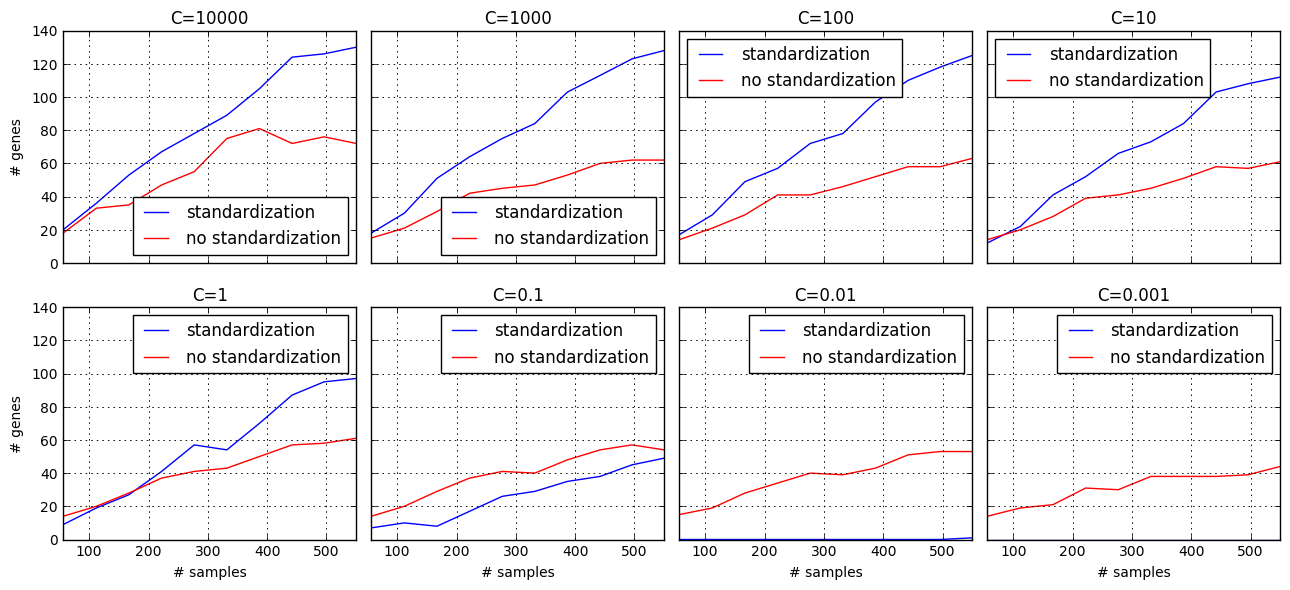

In [23]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(13, 6))
axes = axes.ravel()

for k, curr_c in enumerate(reversed(Cs)):
    ax = axes[k]
    _df1 = df_res_ref.query('C == {0}'.format(curr_c)).copy()
    _df2 = df_res_no_stand.query('C == {0}'.format(curr_c)).copy()
    _df1.sort_values('num_samples', inplace=True)
    _df2.sort_values('num_samples', inplace=True)

    _df1.plot(ax=ax, x='num_samples', color='blue', y='num_genes_selected', label='standardization')
    _df2.plot(ax=ax, x='num_samples', color='red',  y='num_genes_selected', label='no standardization')

    if curr_c < 1:
        label = 'C={0}'.format(curr_c)
    else:
        label = 'C={0:.0f}'.format(curr_c)
        
    ax.set_title(label)
    ax.set_xlabel('# samples')
    ax.set_ylabel('# genes')
    ax.grid(which='both')

plt.tight_layout()